In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

### Load Data


In [4]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print("First eight words:", words[:8])
print(f"Number of total words: {len(words)}")

First eight words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of total words: 32033


### Build Vocabulary


In [5]:
# build the vocabulary of characters and mappings to/from integers
vocab = sorted(list(set("".join(words))))
vocab.insert(0, ".")
vocab_to_idx_lookup = {s: i for i, s in enumerate(vocab)}
idx_to_vocab_lookup = {i: s for s, i in vocab_to_idx_lookup.items()}
VOCAB_SIZE = len(vocab)
print(f"Char ID to Char Look Up Table: {idx_to_vocab_lookup}")
print(f"Char to Char ID Look Up Table: {vocab_to_idx_lookup}")

Char ID to Char Look Up Table: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Char to Char ID Look Up Table: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


### Define Build Dataset Helper fn


In [11]:
def build_dataset(words, block_size: int):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            # print(ch)
            ix = vocab_to_idx_lookup[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(idx_to_vocab_lookup[i] for i in context), '--->', idx_to_vocab_lookup[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

## A.Step Through Neural Network Forward Calc

### A1: Define Hyper-parameters, Build Dataset


In [12]:
BLOCK_SIZE = 3
N_EMB_DIM = 10
HIDDEN_LAYER_SIZE = 100

random.seed(42)
random.shuffle(words)
X, Y = build_dataset(words, block_size=BLOCK_SIZE)
N_OBS = len(X)


torch.Size([228146, 3]) torch.Size([228146])


### A2: Build Embeddings Look Up Table


In [13]:
C = torch.randn((VOCAB_SIZE, N_EMB_DIM))
emb = C[X]
emb.shape

torch.Size([228146, 3, 10])

### A3: Init Hidden Layer Params


In [15]:
W1 = torch.randn((BLOCK_SIZE * N_EMB_DIM, HIDDEN_LAYER_SIZE))
b1 = torch.randn(HIDDEN_LAYER_SIZE)
print(f"W1:\n{W1}\nShape:\n{W1.shape}\n")
print(f"b1:\n{b1}\nShape:\n{b1.shape}")

W1:
tensor([[ 0.3494,  1.5772,  0.1810,  ..., -1.0410, -1.4707,  1.4730],
        [-0.9566, -0.5675, -1.0856,  ..., -0.4627,  0.1218,  0.1975],
        [ 1.3698,  0.5055, -0.0487,  ...,  1.8031, -0.3263, -0.1248],
        ...,
        [ 1.2445, -1.6096, -0.7791,  ..., -1.0290, -0.6817,  0.5691],
        [ 0.6661,  1.5103,  1.0703,  ...,  2.6169, -0.5904, -1.4249],
        [-1.5001, -1.4129,  0.7260,  ...,  0.8760,  0.7315, -0.9346]])
Shape:
torch.Size([30, 100])

b1:
tensor([ 1.2310, -0.5046, -1.4908, -0.8933, -1.7085, -0.0649,  1.1201, -0.6028,
        -1.8755, -0.3014, -1.0861, -0.8184,  2.0332, -1.6157, -0.6922, -0.9235,
        -0.0323, -0.5249, -0.9747, -1.8774,  0.0724, -0.8123, -0.9235, -1.2178,
         0.1043,  0.3548,  1.4879,  2.0114,  0.5119, -0.1295, -0.3020, -0.6994,
        -0.1444,  0.9183,  0.2746,  0.5137, -0.4459, -1.2979,  0.8191, -0.3068,
        -1.5361, -2.0700, -2.3479,  1.2261,  0.5557,  0.7605,  0.8966,  0.0257,
         0.2352,  1.0934, -0.0156, -0.1613, -0.3

### A4: Calc Hidden Layer Outputs


In [16]:
h = torch.tanh(emb.view(-1, BLOCK_SIZE * N_EMB_DIM) @ W1 + b1)
print(f"Hidden Layer Outputs:\n{h}\nShape:\n{h.shape}")

Hidden Layer Outputs:
tensor([[ 0.9999,  1.0000, -1.0000,  ..., -1.0000,  0.9999, -0.9764],
        [ 0.9939,  0.9999, -1.0000,  ...,  1.0000,  0.9997, -0.9996],
        [ 0.9935, -0.9882, -1.0000,  ..., -1.0000, -0.9981,  0.9999],
        ...,
        [ 0.9999, -0.4502, -0.9966,  ...,  0.9999,  0.8740,  0.9974],
        [ 1.0000, -1.0000,  1.0000,  ...,  0.2447, -0.7778, -0.9888],
        [-0.9995,  0.9944, -0.9999,  ..., -0.9996,  0.9618,  0.9995]])
Shape:
torch.Size([228146, 100])


### A5: Init Output Layer Params, Calc Conditional PMFs of Next Character


In [17]:
W2 = torch.randn((HIDDEN_LAYER_SIZE, VOCAB_SIZE))
b2 = torch.randn(VOCAB_SIZE)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape
print(f"W2:\n{W2}\nShape:\n{W2.shape}\n")
print(f"b2:\n{b1}\nShape:\n{b2.shape}\n")
print(f"logits:\n{logits}\nShape:\n{logits.shape}\n")
print(f"probabilities:\n{prob}\nShape:\n{prob.shape}")

W2:
tensor([[-0.7634, -0.5003, -1.1230,  ...,  1.5821,  1.8654, -0.4528],
        [ 1.4357,  1.4322, -0.8836,  ..., -0.3019,  0.3110, -1.5794],
        [ 0.0525,  1.4069,  0.2308,  ...,  1.2044,  0.7844, -1.6449],
        ...,
        [-1.5921, -0.7209, -0.6205,  ..., -0.0089, -1.9234,  0.6996],
        [-0.7075,  0.6972, -0.7930,  ...,  1.5005,  0.0862, -1.9020],
        [-0.1768, -0.6761,  0.0529,  ..., -0.2910, -1.2700,  0.5148]])
Shape:
torch.Size([100, 27])

b2:
tensor([ 1.2310, -0.5046, -1.4908, -0.8933, -1.7085, -0.0649,  1.1201, -0.6028,
        -1.8755, -0.3014, -1.0861, -0.8184,  2.0332, -1.6157, -0.6922, -0.9235,
        -0.0323, -0.5249, -0.9747, -1.8774,  0.0724, -0.8123, -0.9235, -1.2178,
         0.1043,  0.3548,  1.4879,  2.0114,  0.5119, -0.1295, -0.3020, -0.6994,
        -0.1444,  0.9183,  0.2746,  0.5137, -0.4459, -1.2979,  0.8191, -0.3068,
        -1.5361, -2.0700, -2.3479,  1.2261,  0.5557,  0.7605,  0.8966,  0.0257,
         0.2352,  1.0934, -0.0156, -0.1613, -0.3

### A6: Calc Log Likelihood (Loss)


In [18]:
loss = -prob[torch.arange(N_OBS), Y].log().mean().item()
print(f"Negative Log Likelihood (Loss Over Entire Dataset) = {loss:.3f}")

Negative Log Likelihood (Loss Over Entire Dataset) = 19.343


## B. Create Training Loop & Iteratively Train Neural Net


### B1. Define Helper Functions for Training


In [20]:
def init_params(block_size: int, n_emb_dim: int, hidden_layer_size: int):
    g = torch.Generator().manual_seed(2147483647)  # for reproducibility
    C = torch.randn((VOCAB_SIZE, n_emb_dim), generator=g)
    W1 = torch.randn((int(block_size * n_emb_dim), hidden_layer_size), generator=g)
    b1 = torch.randn(hidden_layer_size, generator=g)
    W2 = torch.randn((hidden_layer_size, VOCAB_SIZE), generator=g)
    b2 = torch.randn(VOCAB_SIZE, generator=g)
    return C, W1, b1, W2, b2


def score_mlp(
    X: torch.Tensor,
    Y: torch.Tensor,
    block_size: int,
    n_emb_dim: int,
    C: torch.Tensor,
    W1: torch.Tensor,
    b1: torch.Tensor,
    W2: torch.Tensor,
    b2: torch.Tensor,
) -> float:
    emb = C[X]  # (BATCH_SIZE, BLOCK_SIZE, N_EMB_DIM)
    h = torch.tanh(
        emb.view(-1, int(block_size * n_emb_dim)) @ W1 + b1
    )  # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
    logits = h @ W2 + b2  # (BATCH_SIZE, VOCAB_SIZE)
    loss = F.cross_entropy(logits, Y).item()
    return loss


def plot_train_loss_vs_step(
    losses: torch.Tensor,
    title: str = "Training Iteration vs Loss",
    x_label: str = "Training Iteration",
    y_label: str = "Loss",
):
    steps = torch.arange(len(losses))

    fig, ax = plt.subplots()
    ax.plot(steps, losses)
    plt.title(title)
    plt.ylabel(x_label)
    plt.xlabel(y_label)
    plt.show()
    plt.close(fig)  # Close and delete the figure to free memory
    del fig


def plot_train_loss_vs_log_learning_rate(
    losses: torch.Tensor,
    learning_rates: torch.Tensor,
    title: str = "Log Training Learning Rate vs Loss",
    x_label: str = "Log Training Learning Rate",
    y_label: str = "Loss",
):
    assert losses.shape[0] == learning_rates.shape[0]
    assert len(losses.shape) == 1
    assert len(learning_rates.shape) == 1

    fig, ax = plt.subplots()
    ax.plot(learning_rates.log10(), losses)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    plt.close(fig)  # Close and delete the figure to free memory
    del fig


def train_mlp(
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    batch_size: int,
    block_size: int,
    n_emb_dim: int,
    C: torch.Tensor,
    W1: torch.Tensor,
    b1: torch.Tensor,
    W2: torch.Tensor,
    b2: torch.Tensor,
    n_iter: int,
    log_learning_rate_start: float,
    log_learning_rate_end: float,
) -> tuple[torch.tensor, torch.tensor, torch.tensor]:
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    print(f"Num Params: {sum(p.nelement() for p in parameters)}")

    learning_rates = 10 ** torch.linspace(
        log_learning_rate_start, log_learning_rate_end, n_iter
    )

    losses = torch.zeros(n_iter)

    for i in range(n_iter):
        # minibatch construct
        ix = torch.randint(0, X_train.shape[0], (batch_size,))

        # forward pass
        emb = C[X_train[ix]]  # (BATCH_SIZE, BLOCK_SIZE, N_EMB_DIM)
        h = torch.tanh(
            emb.view(-1, int(block_size * n_emb_dim)) @ W1 + b1
        )  # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
        logits = h @ W2 + b2  # (BATCH_SIZE, VOCAB_SIZE)
        loss = F.cross_entropy(logits, Y_train[ix])
        # print(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr_i = learning_rates[i]
        for p in parameters:
            p.data += -lr_i * p.grad

        # track stats
        losses[i] = loss.item()

    in_sample_loss = score_mlp(
        X_train,
        Y_train,
        block_size=block_size,
        n_emb_dim=n_emb_dim,
        C=C,
        W1=W1,
        b1=b1,
        W2=W2,
        b2=b2,
    )
    print(f"Training Set (In Sample) Loss: {in_sample_loss:.3f}")

    return losses, logits, learning_rates


### B2. Define New Hyper-parameters For Training, Split Data


In [21]:
# Set Hyper Params
BLOCK_SIZE = 3
N_EMB_DIM = 10
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 256
N_ITER = int(2e5)
N_WARM_UP_ITER = int(N_ITER // 4)

# split data
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1], block_size=BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=BLOCK_SIZE)
Xte, Yte = build_dataset(words[n2:], block_size=BLOCK_SIZE)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### B3. Init Hidden Layer and Output Layer Parameters


In [22]:
C, W1, b1, W2, b2 = init_params(
    block_size=BLOCK_SIZE, n_emb_dim=N_EMB_DIM, hidden_layer_size=HIDDEN_LAYER_SIZE
)

### B4. Warm Up

- Forward Calc Loss -> Backprop to Calc Gradient -> Update Params
- Iterate through learning rates getting exponentially larger until the optimizer diverges to find ideal starting learning rate


Num Params: 6097
Training Set (In Sample) Loss: 46.537


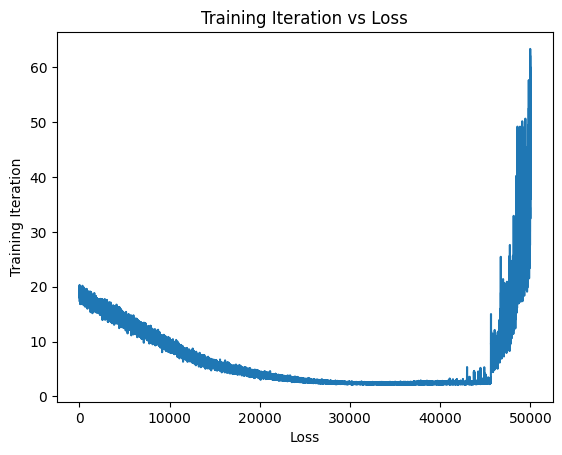

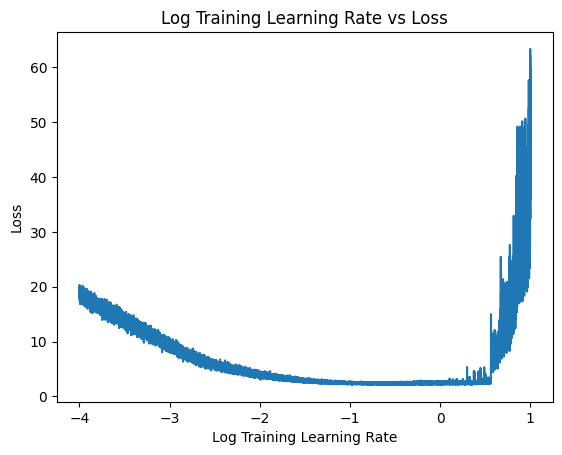

In [14]:
warm_up_losses, warm_up_logits, warm_up_learning_rates = train_mlp(
    Xtr,
    Ytr,
    batch_size=BATCH_SIZE,
    block_size=BLOCK_SIZE,
    n_emb_dim=N_EMB_DIM,
    C=C,
    W1=W1,
    W2=W2,
    b1=b1,
    b2=b2,
    n_iter=N_WARM_UP_ITER,
    log_learning_rate_start=-4.0,
    log_learning_rate_end=1.0,
)

plot_train_loss_vs_step(warm_up_losses)
plot_train_loss_vs_log_learning_rate(warm_up_losses, warm_up_learning_rates)


Num Params: 6097
Training Set (In Sample) Loss: 2.102


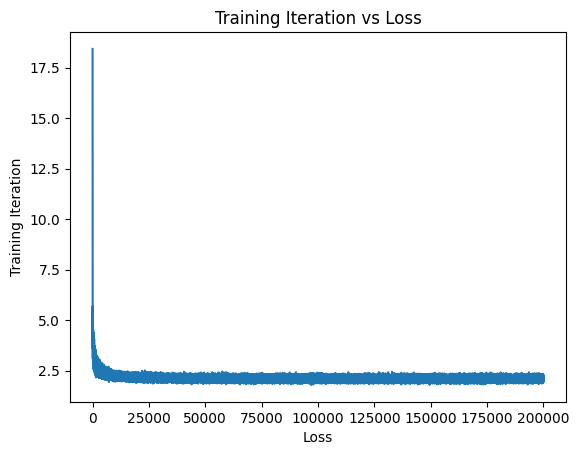

In [15]:
C, W1, b1, W2, b2 = init_params(
    block_size=BLOCK_SIZE, n_emb_dim=N_EMB_DIM, hidden_layer_size=HIDDEN_LAYER_SIZE
)  # reinit

train_losses, train_logits, train_learning_rates = train_mlp(
    Xtr,
    Ytr,
    batch_size=BATCH_SIZE,
    block_size=BLOCK_SIZE,
    n_emb_dim=N_EMB_DIM,
    C=C,
    W1=W1,
    W2=W2,
    b1=b1,
    b2=b2,
    n_iter=N_ITER,
    log_learning_rate_start=0.0,
    log_learning_rate_end=-4.0,
)

plot_train_loss_vs_step(train_losses)


## Can we beat 2.1701 Dev Loss?


In [16]:
out_of_sample_loss = score_mlp(
    Xdev,
    Ydev,
    block_size=BLOCK_SIZE,
    n_emb_dim=N_EMB_DIM,
    C=C,
    W1=W1,
    b1=b1,
    W2=W2,
    b2=b2,
)

print(f"Test Set (Out of Sample) Loss: {out_of_sample_loss:.3f}")


Test Set (Out of Sample) Loss: 2.141


### Visualize Embeddings


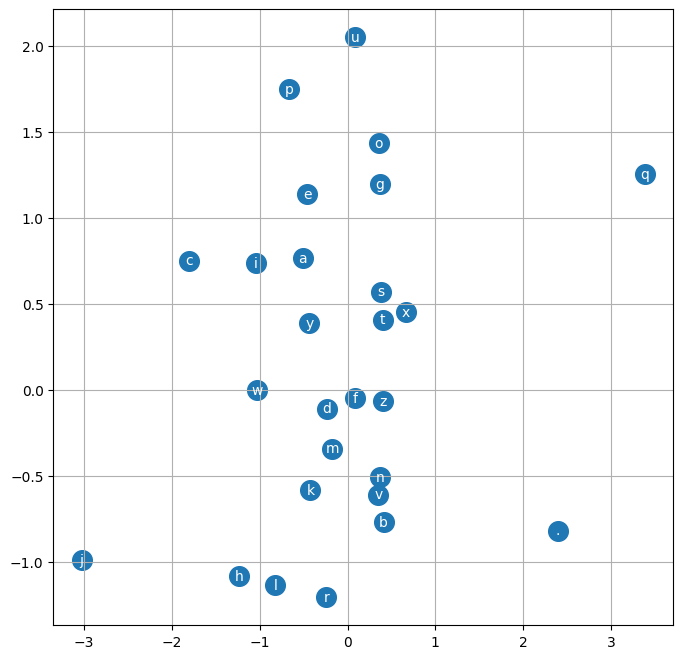

In [17]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        idx_to_vocab_lookup[i],
        ha="center",
        va="center",
        color="white",
    )
plt.grid("minor")


In [18]:
# training split, dev/validation split, test split
# 80%, 10%, 10%


In [19]:
context = [0] * BLOCK_SIZE
C[torch.tensor([context])].shape


torch.Size([1, 3, 10])

In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(idx_to_vocab_lookup[i] for i in out))


carmaizabelle.
khi.
milia.
atleenaasha.
jazhuel.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
join.
quinn.
sulisea.
jadia.
wazelo.
dearyni.
jace.
pirudi.
edde.
